# Implementing facial key point detection

Maintenant que nous avons appris à tirer parti des modèles pré-entraînés pour prédire pour une classe binaire, dans les sections suivantes, nous allons apprendre à tirer parti des modèles pré-entraînés pour résoudre des cas d'utilisation du monde réel qui impliquent les éléments suivants : 

* Régression multiple : prédiction de plusieurs valeurs à partir d'une image en entrée - détection des points clés du visage 

* Apprentissage multi-tâches : prédiction de plusieurs éléments en un seul coup - estimation de l'âge et classification du sexe

Jusqu'à présent, nous avons appris à prédire des classes binaires (chats contre chiens). Apprenons maintenant un problème de régression et, en faisant, une tâche où nous prédisons non pas une mais plusieurs sorties. Imaginez un scénario où l'on vous demande de prédire les points clés présents sur une image d'un visage, par exemple, l'emplacement du yeux, nez et menton. Dans ce scénario, nous devions employer une nouvelle stratégie pour construire un modèle permettant de détecter les points clés.

Pour résoudre ce problème, il faudrait d'abord résoudre quelques problèmes

* Les images peuvent être de différentes formes
 * Cela justifie un ajustement des emplacements des points clés tout en ajustant les images pour les amener toutes à une taille d'image standard.

* Les points clés du visage sont similaires aux points d'un nuage de points, mais dispersés en fonction d'un certain motif cette fois.
  * Cela signifie que les valeurs sont comprises entre 0 et 224 si l'image est redimensionnée à une forme de 224 x 224 x 3 

* Normaliser la variable dépendante (l'emplacement des points clés du visage) en fonction de la taille de l'image
 * Les valeurs des points clés sont toujours comprises entre 0 et 1 si l'on considère leur emplacement par rapport aux dimensions de l'image.

* Étant donné que les valeurs des variables dépendantes sont toujours comprises entre o et 1, nous pouvons utiliser une couche sigmoïde à la fin pour récupérer des valeurs qui seront comprises entre 0 et 1.

Formulons le pipeline de résolution de ce cas d'utilisation

* **1.** mportez les packages pertinents et le jeu de données

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import glob
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

* **2.** Téléchargez et importez les données pertinentes. Vous pouvez télécharger les données pertinentes qui contiennent des images et leurs points clés du visage correspondants

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')
data

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 5984, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5984 (delta 0), reused 0 (delta 0), pack-reused 5981
Receiving objects: 100% (5984/5984), 329.50 MiB | 37.45 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Checking out files: 100% (5803/5803), done.


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,131.0,51.0,138.0,56.0,144.0,61.0,146.0,74.0,146.0,87.0,141.0,97.0,136.0,105.0,129.0,107.0,119.0,110.0,108.0,110.0,98.0,110.0,88.0,110.0,78.0,33.0,84.0,35.0,82.0,38.0,...,56.0,126.0,58.0,123.0,64.0,121.0,66.0,121.0,69.0,118.0,74.0,121.0,81.0,121.0,76.0,126.0,71.0,128.0,69.0,128.0,64.0,128.0,61.0,128.0,56.0,126.0,64.0,123.0,66.0,123.0,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,185.0,102.0,192.0,109.0,196.0,117.0,200.0,131.0,200.0,150.0,189.0,161.0,182.0,168.0,175.0,176.0,160.0,179.0,149.0,179.0,138.0,179.0,123.0,176.0,108.0,65.0,114.0,69.0,103.0,72.0,...,102.0,170.0,102.0,159.0,109.0,152.0,113.0,152.0,117.0,148.0,124.0,152.0,135.0,159.0,131.0,167.0,124.0,170.0,120.0,174.0,113.0,174.0,109.0,174.0,102.0,170.0,109.0,159.0,113.0,159.0,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,190.0,89.0,198.0,100.0,202.0,111.0,2

Dans la sortie précédente, la colonne 1 représente le nom de l'image, les colonnes paires représentent la valeur de l'axe x correspondant à chacun des 68 points clés du visage, et le reste des colonnes impaires (sauf la première colonne) représente l'axe y valeur correspondant à chacun des 68 points clés

* **3.** Définir la classe FacesData qui fournit des points de données d'entrée et de sortie pour le chargeur de données

In [3]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2, numpy as np
from copy import deepcopy
class FacesData(Dataset):
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df

        # Définir la moyenne et l'écart type avec lesquels les images doivent être prétraitées afin qu'elles puissent être consommées par le modèle VGG16 pré-entraîné
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    def __len__(self): 
      return len(self.df)

    # Ensuite, nous définissons la méthode __getitem__, où nous récupérons l'image correspondant à un index donné, la redimensionnons, récupérons les valeurs des points
    #clés correspondant à l'index donné, normalisons les points clés afin que nous ayons l'emplacement des points clés en proportion de la taille de l'image, et pré-traiter l'image


    def __getitem__(self, ix):
        #récupérer le chemin de l'image correspondant à un indice donné (ix)
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
        
        #scale l'image 
        img = cv2.imread(img_path)/255.

        # Normaliser les valeurs de sortie attendues (points clés) en proportion de la taille de l'image d'origine
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()

        # Renvoyer les points clés (kp2) et l'image (img) après pré-traitement de l'image
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2) 
        img = self.preprocess_input(img)
        return img, kp2

    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)

    # Définir une fonction pour charger l'image, qui sera utile lorsque l'on voudra visualiser une image test et les points clés prédits de l'image test    
    def load_img(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]        
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

Dans le code précédent, nous nous assurons que les points clés sont fournis en proportion de la taille de l'image d'origine. Ceci est fait de sorte que lorsque nous redimensionnons l'image d'origine, l'emplacement des points clés ne soit pas modifié, car les points clés sont fournis en tant que proportion de l'image d'origine. De plus, en obtenant les points clés en tant que proportion de l'image d'origine, nous avons la valeurs de sortie attendues comprises entre 0 et 1

* **4.** Créons maintenant une division des données d'entraînement et de test et établissons des ensembles de données d'entraînement et de test et des chargeurs de données

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

* **5.** Définissons maintenant le modèle que nous allons exploiter pour identifier les points clés d'une image

In [5]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential( nn.Conv2d(512,512,3),
      nn.MaxPool2d(2),
      nn.Flatten())
    model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
    )
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer


Notez que la dernière couche du modèle dans le module de classification est une fonction asigmoïde qui renvoie une valeur comprise entre o et 1 et que la sortie attendue sera toujours comprise entre 0 et 1 car les emplacements des points clés sont une fraction des dimensions de l'image d'origine.

Notez que la fonction de perte est L1Loss, en d'autres termes, nous effectuons une réduction d'erreur absolue moyenne sur la prédiction de l'emplacement des points clés du visage (qui sera prédit en pourcentage de la largeur et de la hauteur de l'image)

Obtenez le modèle, la fonction de perte et l'optimiseur correspondant

In [6]:
model, criterion, optimizer = get_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

* **7.** Définir des fonctions à entraîner sur un lot de points de données et également à valider sur le jeu de données de test

In [7]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

In [8]:
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [9]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item() 
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item() 
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1 : 50


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 epoch 2 : 50
 epoch 3 : 50
 epoch 4 : 50
 epoch 5 : 50
 epoch 6 : 50
 epoch 7 : 50
 epoch 8 : 50
 epoch 9 : 50
 epoch 10 : 50
 epoch 11 : 50
 epoch 12 : 50
 epoch 13 : 50
 epoch 14 : 50
 epoch 15 : 50
 epoch 16 : 50
 epoch 17 : 50
 epoch 18 : 50
 epoch 19 : 50
 epoch 20 : 50
 epoch 21 : 50
 epoch 22 : 50
 epoch 23 : 50
 epoch 24 : 50
 epoch 25 : 50
 epoch 26 : 50
 epoch 27 : 50
 epoch 28 : 50
 epoch 29 : 50
 epoch 30 : 50
 epoch 31 : 50
 epoch 32 : 50
 epoch 33 : 50
 epoch 34 : 50
 epoch 35 : 50
 epoch 36 : 50
 epoch 37 : 50
 epoch 38 : 50
 epoch 39 : 50
 epoch 40 : 50
 epoch 41 : 50
 epoch 42 : 50
 epoch 43 : 50
 epoch 44 : 50
 epoch 45 : 50
 epoch 46 : 50
 epoch 47 : 50
 epoch 48 : 50
 epoch 49 : 50
 epoch 50 : 50


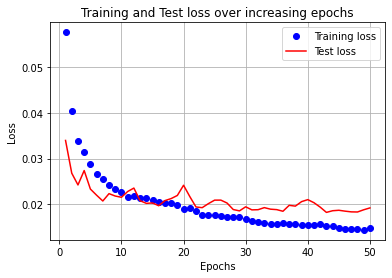

In [10]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

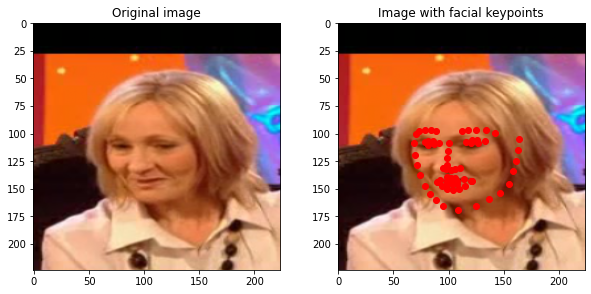

In [11]:

ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()